# TextRank

## 핵심단어/문장 구하기

### 1. 핵심단어 구하기

1-1. 파일 읽기<br>
1-2. 문장 Tokenize 하기<br>
1-3. 단어 index 만들기<br>
1-4. word 그래프 만들기<br>
1-5. 그래프에 PageRank 적용<br>

In [1]:
import numpy as np
from konlpy.tag import Kkma
from collections import Counter
from collections import defaultdict
from scipy.sparse import csr_matrix
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib


#### 1-1. 파일 읽기

In [2]:
with open('./test1.txt', encoding='utf-8') as f:
    sents = [sent for row in f for sent in row.strip().split(". ") if len(sent) > 0 ]

In [3]:
sents

['인공신경망(artificial neural network, ANN)은 기계학습과 인지과학에서 생물학의 신경망에서 영감을 얻은 통계학적 학습 알고리즘으로 시냅스의 결합으로 네트워크를 형성한 인공 뉴런(노드)이 학습을 통해 시냅스의 결합 세기를 변화시켜, 문제 해결 능력을 가지는 모델 전반을 가리킨다',
 '인공신경망에는 교사 신호(정답)의 입력에 의해서 문제에 최적화되어 가는 교사 학습과 교사 신호를 필요로 하지 않는 비교사 학습이 있다',
 '명확한 해답이 있는 경우에는 교사 학습이, 데이터 클러스터링에는 비교사 학습이 이용된다',
 '다른 기계학습과 같이 신경망은 일반적으로 규칙기반 프로그래밍으로 풀기 어려운 컴퓨터 비전 또는 음성 인식과 같은 다양한 범위의 문제를 푸는데 이용된다.']

In [4]:
# sents = ['바나나 사과 딸기 바나나 딸기 바나나 키위 파인애플 바나나 바나나 딸기 바나나',
#         '사과 바나나 바나나 딸기 사과 사과 파인애플 딸기 파인애플 딸기 딸기 ']

#### 1-2. 문장 Tokenize 하기

kkma 라이브러리를 이용해 NN, VA, VV 인 단어들만 추출한다.

In [5]:
kkma = Kkma()
tokens =[]
for sent in sents:
    if len(sent) == 0:
        continue
    words = kkma.pos(sent)
#     print(words)
    words = [word_t[0] for word_t in words 
             if ( 'NN' in word_t[1] or 'VA' in word_t[1] or 'VV' in word_t[1])]
    tokens.append(words)

In [6]:
print(tokens)

[['인공', '신경망', '은', '기계', '학습', '인지', '과학', '생물학', '신경망', '영감', '얻', '통계', '학적', '학습', '알고리즘', '시냅스', '결합', '네트워크', '형성', '인공', '뉴런', '노드', '이', '학습', '통하', '시냅스', '결합', '세기', '변화', '문제', '해결', '능력', '가지', '모델', '전반', '가리키'], ['인공', '신경망', '교사', '신호', '정답', '의', '입력', '의하', '문제', '최적화되', '갈', '교사', '학습', '교사', '신호', '필요', '하', '비', '교사', '학습'], ['해답', '있', '경우', '교사', '학습', '데이터', '크', '러', '스터링', '비', '교사', '학습', '이용'], ['기계', '학습', '신경망', '일반적', '규칙', '기반', '프로그래밍', '풀', '어렵', '컴퓨터', '비전', '음성', '인식', '같', '다양', '범위', '문제', '푸', '이용']]


#### 1-3. 단어 index 만들기

문서에서 출현 빈도가 min_count 이상인 단어들을 모아 index 를 만든다.

In [7]:
word_counter = Counter(w for words in tokens for w in words)
print(word_counter)

Counter({'학습': 8, '교사': 6, '신경망': 4, '인공': 3, '문제': 3, '기계': 2, '시냅스': 2, '결합': 2, '신호': 2, '비': 2, '이용': 2, '은': 1, '인지': 1, '과학': 1, '생물학': 1, '영감': 1, '얻': 1, '통계': 1, '학적': 1, '알고리즘': 1, '네트워크': 1, '형성': 1, '뉴런': 1, '노드': 1, '이': 1, '통하': 1, '세기': 1, '변화': 1, '해결': 1, '능력': 1, '가지': 1, '모델': 1, '전반': 1, '가리키': 1, '정답': 1, '의': 1, '입력': 1, '의하': 1, '최적화되': 1, '갈': 1, '필요': 1, '하': 1, '해답': 1, '있': 1, '경우': 1, '데이터': 1, '크': 1, '러': 1, '스터링': 1, '일반적': 1, '규칙': 1, '기반': 1, '프로그래밍': 1, '풀': 1, '어렵': 1, '컴퓨터': 1, '비전': 1, '음성': 1, '인식': 1, '같': 1, '다양': 1, '범위': 1, '푸': 1})


In [8]:
min_count=2 # Minumum term frequency
min_word_counter = {w:c for w,c in word_counter.items() if c >= min_count}
print(min_word_counter)

{'인공': 3, '신경망': 4, '기계': 2, '학습': 8, '시냅스': 2, '결합': 2, '문제': 3, '교사': 6, '신호': 2, '비': 2, '이용': 2}


In [9]:
## idx_to_vocab -> data type : list
## Word list corresponding row and column
idx_to_vocab = [w for w, _ in sorted(min_word_counter.items(), key=lambda x:-x[1])] 
print("정렬 확인 >> ", sorted(min_word_counter.items(), key=lambda x:-x[1])) # 1번째 요소로 내림차순(-) 정렬
print()
print("정렬을 기준으로 단어 list 생성 >> ", idx_to_vocab)

정렬 확인 >>  [('학습', 8), ('교사', 6), ('신경망', 4), ('인공', 3), ('문제', 3), ('기계', 2), ('시냅스', 2), ('결합', 2), ('신호', 2), ('비', 2), ('이용', 2)]

정렬을 기준으로 단어 list 생성 >>  ['학습', '교사', '신경망', '인공', '문제', '기계', '시냅스', '결합', '신호', '비', '이용']


In [10]:
## vocab_to_idx -> data type : dict
## Vocabulary to index mapper
vocab_to_idx = {vocab:idx for idx, vocab in enumerate(idx_to_vocab)}
print("빈도 순으로 정렬한 list에 번호를 매겨 index 생성\n", vocab_to_idx)  

빈도 순으로 정렬한 list에 번호를 매겨 index 생성
 {'학습': 0, '교사': 1, '신경망': 2, '인공': 3, '문제': 4, '기계': 5, '시냅스': 6, '결합': 7, '신호': 8, '비': 9, '이용': 10}


#### 1-4. word 그래프 만들기

그래프를 구현하는데에는 co-occcurrence 행렬을 사용한다.<br>
co-occcurrence(동시출현)는 한 문장, 문단 또는 텍스트 단위에서 같이 출현한 단어이다.<br>

In [11]:
## make co-occurrence matrix 
## co-occurrence matrix : scipy.sparse.csr_matrix
##                shape = (n_vocabs, n_vocabs)
## tokenized_sentes -> list of list of str ( Tokenized sentence list )

min_cooccurrence = 1       # Minimum cooccurrence frequency
min_count = 2              # Minumum term frequency
window =1                  # Co-occurrence window size

# print()
counter = defaultdict(int)
for s, tokens_i in enumerate(tokens):
    
    print("문장에서 분리된 단어 중에서 >>  ", tokens_i,"\n")
    vocabs = [vocab_to_idx[w] for w in tokens_i if w in vocab_to_idx]
    print("일정 빈도 수 이상인 것의 index >> ", vocabs,"\n\n")
    
    n = len(vocabs)
    for i, v in enumerate(vocabs): 
        if window <= 0:
            b, e = 0, n
        else:
            b = max(0, i - window)
            e = min(i + window, n)
            
        for j in range(b, e):
            if i == j:
                continue
            counter[(v, vocabs[j])] += 1
            counter[(vocabs[j], v)] += 1

문장에서 분리된 단어 중에서 >>   ['인공', '신경망', '은', '기계', '학습', '인지', '과학', '생물학', '신경망', '영감', '얻', '통계', '학적', '학습', '알고리즘', '시냅스', '결합', '네트워크', '형성', '인공', '뉴런', '노드', '이', '학습', '통하', '시냅스', '결합', '세기', '변화', '문제', '해결', '능력', '가지', '모델', '전반', '가리키'] 

일정 빈도 수 이상인 것의 index >>  [3, 2, 5, 0, 2, 0, 6, 7, 3, 0, 6, 7, 4] 


문장에서 분리된 단어 중에서 >>   ['인공', '신경망', '교사', '신호', '정답', '의', '입력', '의하', '문제', '최적화되', '갈', '교사', '학습', '교사', '신호', '필요', '하', '비', '교사', '학습'] 

일정 빈도 수 이상인 것의 index >>  [3, 2, 1, 8, 4, 1, 0, 1, 8, 9, 1, 0] 


문장에서 분리된 단어 중에서 >>   ['해답', '있', '경우', '교사', '학습', '데이터', '크', '러', '스터링', '비', '교사', '학습', '이용'] 

일정 빈도 수 이상인 것의 index >>  [1, 0, 9, 1, 0, 10] 


문장에서 분리된 단어 중에서 >>   ['기계', '학습', '신경망', '일반적', '규칙', '기반', '프로그래밍', '풀', '어렵', '컴퓨터', '비전', '음성', '인식', '같', '다양', '범위', '문제', '푸', '이용'] 

일정 빈도 수 이상인 것의 index >>  [5, 0, 2, 4, 10] 




In [12]:
counter = {k:v for k,v in counter.items() if v >= min_cooccurrence}
n_vocabs = len(vocab_to_idx)
print(counter)

{(2, 3): 2, (3, 2): 2, (5, 2): 1, (2, 5): 1, (0, 5): 2, (5, 0): 2, (2, 0): 3, (0, 2): 3, (6, 0): 2, (0, 6): 2, (7, 6): 2, (6, 7): 2, (3, 7): 1, (7, 3): 1, (0, 3): 1, (3, 0): 1, (4, 7): 1, (7, 4): 1, (1, 2): 1, (2, 1): 1, (8, 1): 2, (1, 8): 2, (4, 8): 1, (8, 4): 1, (1, 4): 1, (4, 1): 1, (0, 1): 5, (1, 0): 5, (9, 8): 1, (8, 9): 1, (1, 9): 2, (9, 1): 2, (9, 0): 1, (0, 9): 1, (10, 0): 1, (0, 10): 1, (4, 2): 1, (2, 4): 1, (10, 4): 1, (4, 10): 1}


(row, cols):data 형태로 값을 가지고 있는 dictionary를 matrix 형태로 변환

In [13]:
## convert dictionary to matrix
n_rows = n_vocabs
n_cols = n_vocabs
d = counter
rows, cols, data = [], [], []

for (i, j), v in d.items():
    rows.append(i)
    cols.append(j)
    data.append(v)

mat_co_occurr = csr_matrix((data, (rows, cols)), shape=(n_rows, n_cols))

In [14]:
mat_co_occurr.todense()          # 각 행렬에서 나타나는 단어는 vocab_to_idx 에서 확인 가능 

matrix([[0, 5, 3, 1, 0, 2, 2, 0, 0, 1, 1],
        [5, 0, 1, 0, 1, 0, 0, 0, 2, 2, 0],
        [3, 1, 0, 2, 1, 1, 0, 0, 0, 0, 0],
        [1, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1],
        [2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 2, 0, 0, 0, 0],
        [0, 2, 0, 0, 1, 0, 0, 0, 0, 1, 0],
        [1, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]])

#### 1-5. 만들어진 그래프에 PageRank 적용

##### PageRank

$PR(u) = c*\Sigma_{ v ∈ B_{u}} \frac{PR(v)}{N_{v}} + {(1-c)}$ <br>

$B_{u}$ 는 page $u$ 의 backlinks 의 출발점 마디이고, $v$ -> $u$로 연결이 있다. <br>
$N_{v}$ 는 $v$가 가진 link 의 개수<br>
$c$는 dampling factor 로 그래프의 다른 vertex로 이동할 확률<br>
$1-c$는 새롭게 vertex에 유입될 확률 <br>


In [15]:
def pagerank(x, df=0.85, max_iter=30, bias=None):
    """
    Arguments
    ---------
    x : scipy.sparse.csr_matrix
        shape = (n vertex, n vertex)
    df : float
        Damping factor, 0 < df < 1
    max_iter : int
        Maximum number of iteration
    bias : numpy.ndarray or None
        If None, equal bias

    Returns
    -------
    R : numpy.ndarray
        PageRank vector. shape = (n vertex, 1)
    """

    assert 0 < df < 1

    # initialize
    A = normalize(x, axis=0, norm='l1')   # column 의 sum 이 1이 되도록 L1 normalization
    print("transition matrix : A\n", A.todense())
    R = np.ones(A.shape[0]).reshape(-1,1) # 처음 rank 값은 1로 시작
    print(R)
    
    # check bias
    if bias is None:
        bias = ((1 - df) * np.ones(A.shape[0]).reshape(-1,1)) #/N # 전체 마디 N..
    else:
        bias = bias.reshape(-1,1)
        bias = A.shape[0] * bias / bias.sum()
        assert bias.shape[0] == A.shape[0]
        bias = (1 - df) * bias

    # iteration
    for i in range(max_iter):    # 행렬곱을 반복하면 값이 변하지 않는 시점 (steady state)이 온다.
        R = df * (A * R) + bias  # A * R -> column j 에서 row i로의 랭킹 R_j
        print(i," >>\n",R, "\n")

    return R


##### Damping Factor
어떤 마구잡이로 웹서핑을 하는 사람이 그 페이지에 만족을 못하고 다른 페이지로 가는 링크를 클릭할 확률<br>
이 값이 0이 되면 pagerank 가 1이 되고 의미가 없음. 0~1사이의 값.<br>

##### max iteration
max_iter 만큼 ranking 값을 반복해서 계산한다.<br>
ranking 값 업데이트를 반복하다보면 값이 변하지 않는 시점(Steady State)가 생긴다.<br>


In [16]:
damping_factor=0.85 
max_iter = 30              # Number of PageRank iterations
topk = 10                   # Number of keywords selected from TextRank

In [17]:
rank = pagerank (mat_co_occurr, damping_factor, max_iter).reshape(-1)

transition matrix : A
 [[0.         0.45454545 0.375      0.25       0.         0.66666667
  0.5        0.         0.         0.25       0.5       ]
 [0.33333333 0.         0.125      0.         0.2        0.
  0.         0.         0.5        0.5        0.        ]
 [0.2        0.09090909 0.         0.5        0.2        0.33333333
  0.         0.         0.         0.         0.        ]
 [0.06666667 0.         0.25       0.         0.         0.
  0.         0.25       0.         0.         0.        ]
 [0.         0.09090909 0.125      0.         0.         0.
  0.         0.25       0.25       0.         0.5       ]
 [0.13333333 0.         0.125      0.         0.         0.
  0.         0.         0.         0.         0.        ]
 [0.13333333 0.         0.         0.         0.         0.
  0.         0.5        0.         0.         0.        ]
 [0.         0.         0.         0.25       0.2        0.
  0.5        0.         0.         0.         0.        ]
 [0.         0.18

In [18]:
print(rank)

[2.35766144 1.72151663 1.30870402 0.72766822 0.92948099 0.5562515
 0.74913718 0.78102437 0.72353787 0.70340519 0.44161259]


In [19]:
rank_top_ten = np.argsort(-rank)[:topk]  # 내림차순으로 정렬한 index
print(rank_top_ten)

[0 1 2 4 7 6 3 8 9 5]


In [20]:
topten_keywords = [(idx_to_vocab[idx], rank[idx]) for idx in rank_top_ten]
print(topten_keywords)

[('학습', 2.3576614369857687), ('교사', 1.7215166308543188), ('신경망', 1.3087040166139103), ('문제', 0.9294809851152348), ('결합', 0.7810243741684996), ('시냅스', 0.7491371803499386), ('인공', 0.7276682157768689), ('신호', 0.7235378729197695), ('비', 0.7034051900688727), ('기계', 0.5562515031740336)]


In [21]:
keywords_key = []
keywords_rank = []
for word, rank in topten_keywords:
    keywords_key.append(word)
    keywords_rank.append(rank)

In [27]:
fm.get_fontconfig_fonts()
# font_location = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_location = '/Library/Fonts/NanumGothicExtraBold.ttf'
# font_location = 'C:/Windows/Fonts/NanumGothic.ttf' # For Windows
fprop = fm.FontProperties(fname=font_location).get_name()

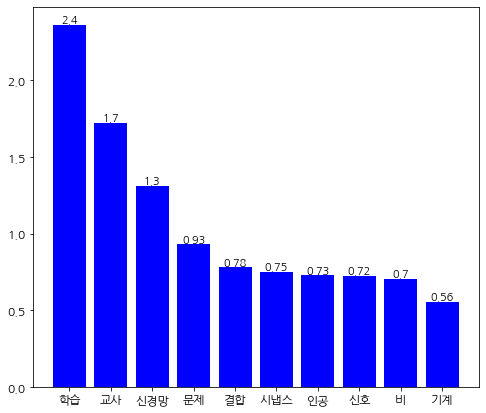

In [29]:
fig = plt.figure(figsize=(8,7))

plt.bar(keywords_key, keywords_rank , color='b')#, align='center')
for i, v in enumerate(keywords_key):
    plt.text(v, keywords_rank[i], '{:.2}'.format(keywords_rank[i]),          
             fontsize = 11, color='black',
             horizontalalignment='center', 
             verticalalignment='bottom')
matplotlib.rc('font', family=fprop, size=12)
plt.show() 

In [24]:
matplotlib.get_cachedir()

'/Users/kimhyerin/.matplotlib'

#### (+) 실제 단어의 빈도수와 keyword 추출 비교

단순히 단어의 빈도 수를 이용해서 확인했을 때와 결과의 차이를 보인다.

In [25]:
counter = Counter(w for words in tokens for w in words)
counter = {w:c for w,c in counter.items() if c >= min_count}
sorted_counter_key = [ l for _,l in sorted([(j,i) for i,j in counter.items()], reverse=True)]
sorted_counter_value = [ k for k,_ in sorted([(j,i) for i,j in counter.items()], reverse=True)]

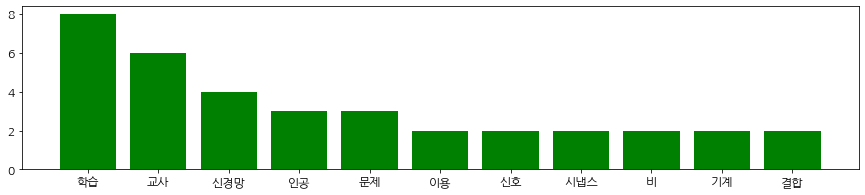

In [26]:
fig = plt.figure(figsize=(15,3))
plt.bar(sorted_counter_key, sorted_counter_value, color='g')
plt.rc('font', family=fprop, size=15)
plt.show() 